In [100]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, LSTM, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import RepeatVector, TimeDistributed, Input, BatchNormalization, multiply, concatenate, Activation, dot
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop,Adam,SGD,Adagrad, Nadam, Ftrl
from keras.utils import plot_model, model_to_dot
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import keras.backend as K
import datetime
from tensorflow.keras import regularizers
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()

In [101]:
def truncate(x, feature_cols=range(1), target_cols=range(1), label_col=1, train_len=100, test_len=20):
    in_, out_= [], []
    for i in range(len(x)-train_len-test_len+1):
        in_.append(x[i:(i+train_len), feature_cols].tolist())
        out_.append(x[(i+train_len):(i+train_len+test_len), target_cols].tolist())
    return np.array(in_), np.array(out_)

In [ ]:
#Preparing Dataset.
fileName = '42001h2021'
dataset = pd.read_csv("42001h2021.txt", sep='\t', lineterminator='\r')
dataset = dataset.replace('\n','', regex=True)
dataset=dataset[1:-1]
dataset["Date"] = pd.to_datetime(dataset["Date"])
dataset["WVHT"]=dataset["WVHT"].astype(float)
dataset = dataset[dataset['WVHT'] != 99]
data = dataset["WVHT"].to_numpy().reshape((len(dataset["WVHT"]),1))
X_in, X_out = truncate(data, feature_cols=range(1), target_cols=range(1),label_col=1, train_len=16, test_len=1)

In [103]:
train_x = X_in[:math.floor(X_in.shape[0]*0.70)]
train_y = X_out[:math.floor(X_out.shape[0]*0.70)]
test_x = X_in[math.floor(X_in.shape[0]*0.70):]
test_y = X_out[math.floor(X_out.shape[0]*0.70):]
print(train_x.shape, test_x.shape,train_y.shape, test_y.shape)

(1577, 16, 1) (677, 16, 1) (1577, 1, 1) (677, 1, 1)


In [104]:
# hyperparameters
r = 0.5
q = 0.95 #Prediction Interval.
delta = 0.001

def confidance_loss(y_true,y_pred):
  y_true = y_true[:,0]
  f1 = y_pred[:,0]
  f2 = y_pred[:,1]

  c1 = (1-q)*(y_true-f2)
  c2 = (1-q)*(f1-y_true)
  c3 = q*(f2-y_true)
  c4 = q*(y_true-f1)

  loss = K.switch(tf.math.logical_and((y_true <= f1),(y_true>=f2)),K.switch((y_true>(r*f1+(1-r)*f2)),c1,c2),K.switch((f2>y_true),c3,c4)) + (delta * tf.math.abs(f1-f2))
  return loss

In [105]:
input_train = Input(shape=(16, 1))
initializer = tf.keras.initializers.GlorotNormal(seed=None)
lstm_l1 = LSTM(128, activation='relu',kernel_initializer=initializer,return_sequences=True)(input_train)
dp_l1 = Dropout(0.4)(lstm_l1)
lstm_l2 = LSTM(64, activation='relu',kernel_initializer=initializer,return_sequences=True)(dp_l1)
dp_l2 = Dropout(0.3)(lstm_l2)
lstm_l3 = LSTM(32, activation='relu',kernel_initializer=initializer,return_sequences=False)(dp_l2)
dp_l3 = Dropout(0.2)(lstm_l3)
out = Dense(2)(dp_l3)
model = Model(inputs=input_train, outputs=out)

c:\Users\aades\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [106]:
opt = Adam(learning_rate=0.001)
model.compile(loss=confidance_loss,optimizer=opt)
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 16, 1)]           0         
                                                                 
 lstm_27 (LSTM)              (None, 16, 128)           66560     
                                                                 
 dropout_27 (Dropout)        (None, 16, 128)           0         
                                                                 
 lstm_28 (LSTM)              (None, 16, 64)            49408     
                                                                 
 dropout_28 (Dropout)        (None, 16, 64)            0         
                                                                 
 lstm_29 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_29 (Dropout)        (None, 32)                0   

In [107]:
epc = 300
start_time = datetime.datetime.now()
stop_patience = 5
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=stop_patience, mode='min')
history = model.fit(train_x, train_y, validation_split=0.1, epochs=epc, verbose=1, batch_size=128)
end_time = datetime.datetime.now()
total_time = end_time - start_time
print('seconds taken:', round(total_time.total_seconds(),1),
	'\nstart_time:', start_time.strftime('%H:%M:%S'),
	'end_time:', end_time.strftime('%H:%M:%S'))

Epoch 1/300
12/12 [==============================] - 13s 200ms/step - loss: 0.9367 - val_loss: 0.2709
Epoch 2/300
12/12 [==============================] - 1s 86ms/step - loss: 0.1740 - val_loss: 0.0757
Epoch 3/300
12/12 [==============================] - 1s 88ms/step - loss: 0.0980 - val_loss: 0.0641
Epoch 4/300
12/12 [==============================] - 1s 89ms/step - loss: 0.0787 - val_loss: 0.0532
Epoch 5/300
12/12 [==============================] - 1s 92ms/step - loss: 0.0639 - val_loss: 0.0451
Epoch 6/300
12/12 [==============================] - 1s 93ms/step - loss: 0.0638 - val_loss: 0.0440
Epoch 7/300
12/12 [==============================] - 1s 95ms/step - loss: 0.0637 - val_loss: 0.0444
Epoch 8/300
12/12 [==============================] - 1s 84ms/step - loss: 0.0574 - val_loss: 0.0418
Epoch 9/300
12/12 [==============================] - 1s 87ms/step - loss: 0.0572 - val_loss: 0.0403
Epoch 10/300
12/12 [==============================] - 1s 82ms/step - loss: 0.0558 - val_loss: 0.04

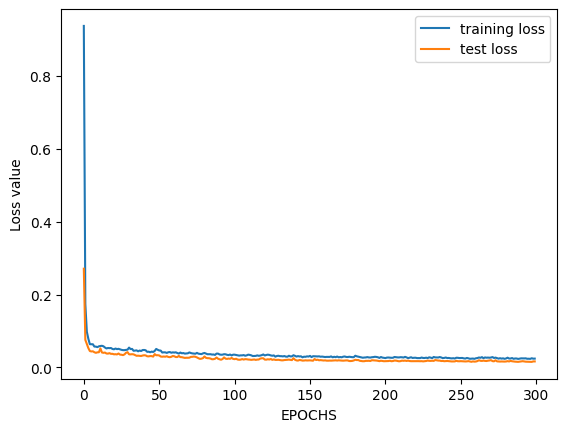

In [108]:
fig,ax = plt.subplots()
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='test loss')
ax.set_xlabel('EPOCHS')
ax.set_ylabel('Loss value')
plt.legend()

In [109]:
y_pred = model.predict(test_x, verbose=0)
test_y_ = np.squeeze(test_y[:,0])
y_u_pred = y_pred[:,0]
y_l_pred = y_pred[:,1]
K_u = y_u_pred > test_y_
K_l = y_l_pred < test_y_
print('PICP:', np.mean(K_u * K_l))
print('MPIW:', np.round(np.mean(y_u_pred - y_l_pred),3))

PICP: 0.9675036927621861
MPIW: 0.324


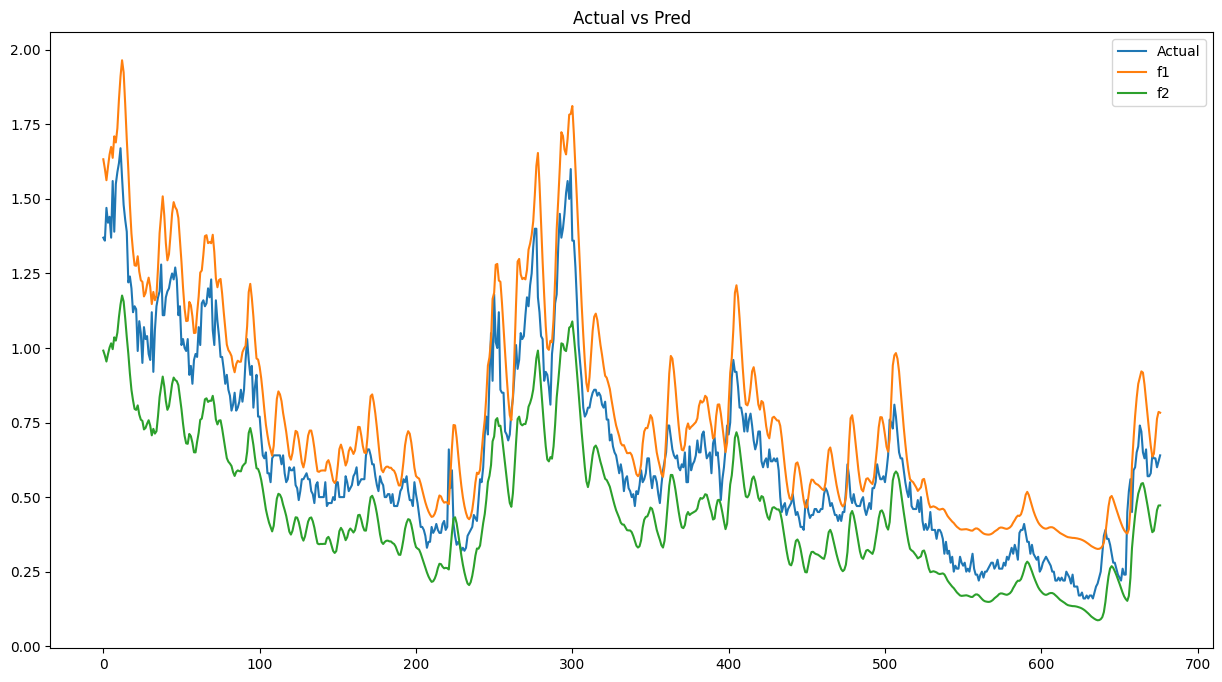

In [110]:
actual=test_y
actual = np.squeeze(actual)
pred1=y_u_pred
pred2=y_l_pred
numEx = range(len(actual))
plt.figure(figsize=(15, 8))
plt.plot(numEx,actual,label='Actual')
plt.plot(numEx,pred1,label='f1')
plt.plot(numEx,pred2,label='f2')
plt.legend(loc='best')
plt.title('Actual vs Pred')
plt.show()